# Overview

With the ubiquity of music streaming apps that predict musical preferences (Spotify, Pandora, etc.), one has to wonder how it is possible to make predictions about someone's taste in something so varied and personal. I have recently learned about how audio signals (particularly voice) are encoded and compressed, and how the first step is to take short time segments and come up with parameters that describe the signal (pitch, gain, spectral frequencies, etc.) I can imagine that maybe some of these parameters are used as features in machine learning algorithms that learn what styles of music you like. This may be either explicitly or implicitly, as in the case of neural networks [1]. 

After learning about UCR's Matrix Profile algorithm suite, I thought that it would be interesting to see if one could derive genre-specific features by analyzing the data from a time series perspective. I downloaded a data set from the UCR Machine Learning repository [2], which included hundreds of thousands of 30 second samples of tracks of various genres and artists [3]. 

I quickly realized the limitation of using the Matrix Profile on raw music data, when I viewed the signal and attempted calculating the MP with various subsequence lengths. One example for which I seemed to have gotten an informative MP is below, but it was hard to achieve this consistently across files.

In [33]:
from matrixprofile import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
%matplotlib inline

Text(0.5, 0, 'Sample')

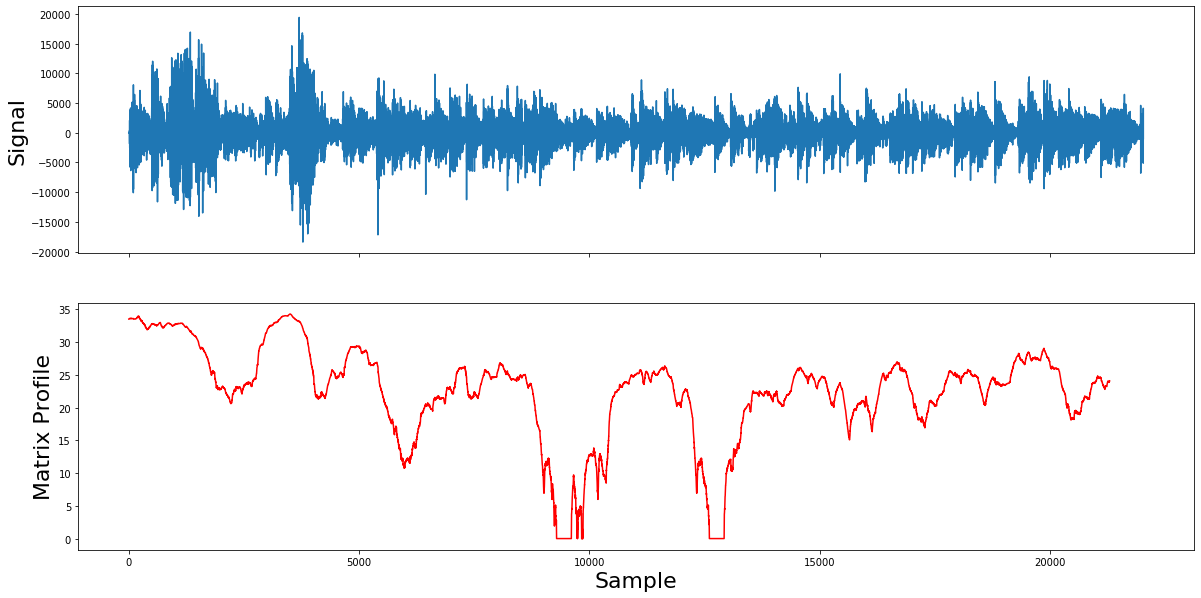

In [34]:
fs,data = wavfile.read('/Applications/Documents/JHU_classes/625.620_MathMeth_SignalProc/project/000/000203.mp3.wav')
pattern = data[:,0]
pattern = pattern[::60]

m = 735 #one second
mp = matrixProfile.stomp(pattern,m)

#Append np.nan to Matrix profile to enable plotting against raw data
mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

#Plot the signal data
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(20,10))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
ax1.set_ylabel('Signal', size=22)

#Plot the Matrix Profile
ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)
ax2.set_xlabel('Sample', size=22)

This difficulty makes perfect sense I think, given the complexity of the music data and all the overlapping instruments. I felt that genre identification would need to involve some more complex preliminary signal processing, so I set my sights on something a bit simpler. 

Inspired by the example problem in 100 Time Series Data Mining Questions that compared Vanilla Ice's 'Ice Ice Baby' to David Bowie & Queen's 'Under Pressure' and showed the plaigiarised base riff [4,slide 6], I recalled a time when I heard a song called 'On' by Daniel Skye and thought 'this sounds remarkably similar to 'Where Is My Mind' by the Pixies.' There was a particular recurring theme that had the same note sequence as 'Where Is My Mind'. (It turns out that a lot of artists have 'taken' this same theme from the Pixies, including 'O Yeah' by End of Fashion, 'Close To Me' by Ellie Goulding, 'Blur' by M0, and likely others [5].) Whether plaigiarism actually occured is another discussion I am not qualified to answer, but I was curious to see if joining both songs and doing a similarity search would validate my righteous claim that the only reason 'On' was so catchy was because it borrowed so heavily from this arguably much more talented musical band. I will also discuss this work here. 

Overall, I hoped that exploring a class of time series data that I was already personally and intuively familiar with would help me focus on the various MP alrogithms (STOMP, in particular), and learn what kinds of questions they were well-suited to answering. I also hoped to learn how to pre-process such data, as I have never handled music files in this way before. 

# Data Preprocessing

First I downloaded .mp3 files of 'On' and 'Where Is My Mind' (and the other songs mentioned in the Overview), and converted them to .wav files using ffmpeg.

In [36]:
# use scipy.io.wavfile to read in the .wav file
fs,data1 = wavfile.read('/Applications/Documents/JHU_classes/625.620_MathMeth_SignalProc/project/ON.wav')
data1

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int16)

In [37]:
fs,data2 = wavfile.read('/Applications/Documents/JHU_classes/625.620_MathMeth_SignalProc/project/Where_Is_My_Mind.wav')
data2

array([[ 67,  15],
       [109,  36],
       [ 97,  52],
       ...,
       [  0,   0],
       [  0,   0],
       [  0,   0]], dtype=int16)

In [38]:
# Take the first of the two channels (arbitrarily)
pattern_on   = data1[:,0]
pattern_wimm = data2[:,0]

# Downsample the data so that one second is ~100 time points
pattern_on   = pattern_on[::400]
pattern_wimm = pattern_wimm[::400]

Before comparing the two songs, I wanted to see the Matrix Profiles for each song, for the same subsequence length that I would be comparing them on (300).

'On' by Daniele Skye:

Text(0.5, 0, 'Sample')

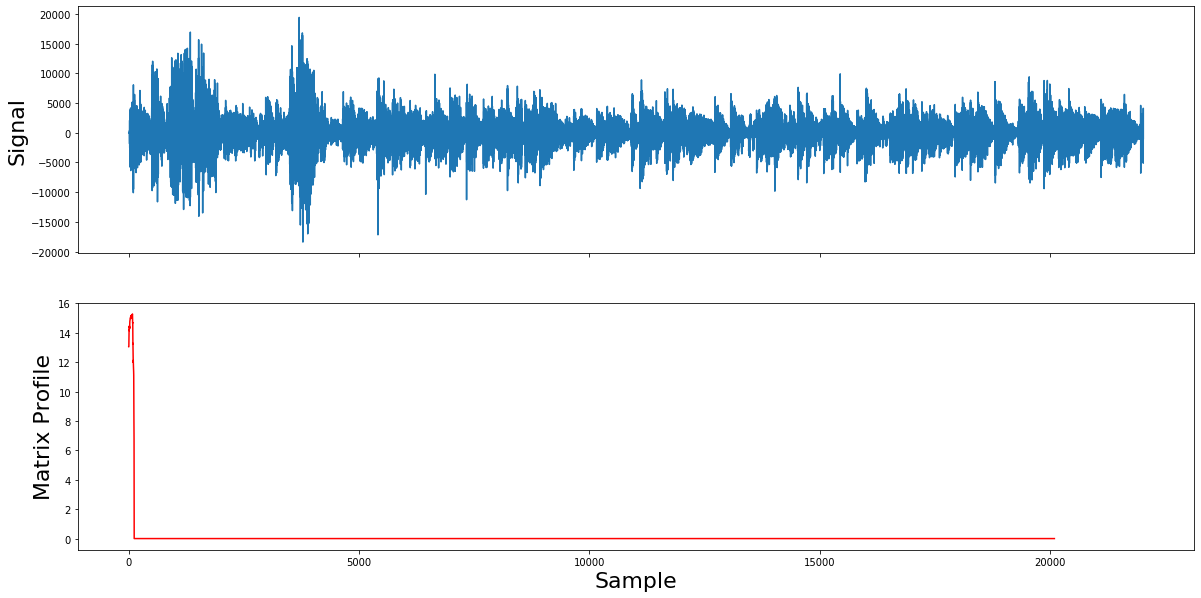

In [39]:
m = 300 # three seconds
mp = matrixProfile.stomp(pattern_on,m)

#Append np.nan to Matrix profile to enable plotting against raw data
mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

#Plot the signal data
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(20,10))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
ax1.set_ylabel('Signal', size=22)

#Plot the Matrix Profile
ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)
ax2.set_xlabel('Sample', size=22)

'Where is My Mind' by The Pixies:

Text(0.5, 0, 'Sample')

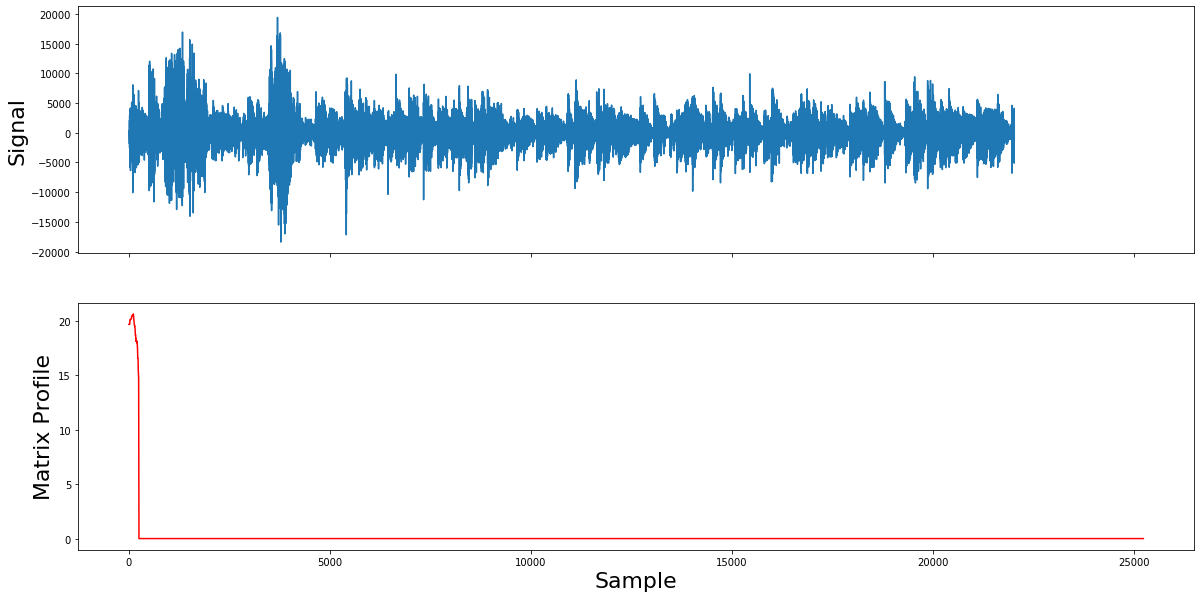

In [40]:
m = 300 # three seconds
mp = matrixProfile.stomp(pattern_wimm,m)

#Append np.nan to Matrix profile to enable plotting against raw data
mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

#Plot the signal data
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(20,10))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
ax1.set_ylabel('Signal', size=22)

#Plot the Matrix Profile
ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)
ax2.set_xlabel('Sample', size=22)

These results were not very promising, but I forged ahead, trusting the inifinite wisdom of UCR in choosing this subsequence length for their similar comparison.
(With more time, I would have really liked to experiment with different subsequence lengths.)

# Stolen Riff?

Now to compare the two songs and see if the riff was recognizable in the signal as a recurring motif, I switched over to MATLAB because I could not find a Python analog for MP's code for doing this.

I imported the time series above into MATLAB, and ran the Matrix Profile MATLAB code provided in the zip file underneath '100 Time Series Data Mining Questions (with Answers!)':

Note: MP claims that smoothing the data is not needed, it's just for visualization purposes. However, I got different results with and without smoothing.

Here is the result with smoothing:

![caption](files/MP_twosongs_smoothed.png)

And without smoothing:

![caption](files/MP_twosongs_nosmoothing.png)

# Analysis

You can see that in the version with smoothing, the sections of the signal highlighted in green and cyan are different from the sections highlighted in the unsmoothed version. Though, it could be that the parts highlighted in blue in the respective results are very similar to each other. 

I am not sure how to assess the accuracy of this motif find - it would be interesting to find the spots in the actual songs and listen to see if they corresponded to what I was looking for. I certainly don't see a motif as well preserved as the one in the example slides.

I think again, the complication of all the combined signals from different instruments may contribute to masking an underlying melody I'm trying to pick up on.

# Other songs similar to 'Where Is My Mind'

'O Yeah' by End of Fashion:

![caption](files/MP_twosongs_yeah.png)

'Blur' by M0:

![caption](files/MP_twosongs_blur.png)

'Close To Me' by Ellie Goulding:

![caption](files/MP_twosongs_closetome.png)

# Analysis of Other Songs

The best-so-far #1 motif from comparing the foundational song 'Where Is My Mind' to 'On', 'O Yeah', and 'Close To Me' are arguably similar. This seems to suggest that it is the same motif being picked out in these three songs, which is what I wanted. 

But overall, again I am not sure what to make of the motifs picked out. I was hoping I would get something that looked as clear as the motif in the example slides. But I am wondering, if my data is complex because there are a lot of components to the song happening simultaneously, why wouldn't that have complicated things for the MP authors who compared 'Under Pressure' to 'Ice Ice Baby'? Did they do any other preprocessing to isolate the bass line? I wish that they had explained in more detail what they did.

Also, different sections of 'Where Is My Mind' are highlighted in the different song comparions. Does this suggest that the results are not actually meaningful? Or is it that the motifs between those sections are similar?

# Conclusion

I thought that learning about the Matrix Profile suite was really interesting, and through the papers the concepts were made fairly straightforward. Though I didn't get results as clean as I'd hoped for, I'm not so surprised and I was still happy to see some Matrix Profiles from real data. It is quite impressive to be able to calculate similarities between every subsequence of length m and every other subsequence of length m, and ultimately get a plot of how dissimilar to the rest of the signal the signal is at a given time point, in such a short amount of time. I can only imagine what a boon this is for researchers working daily with truly large datasets.

On a personal level, by doing this project I learned a lot about the challenges of working with a large dataset! If I had stuck with the initial dataset of song clips and this were a work project, I would have liked to gather some statistics about the dataset as a whole. (The size of the excel file with track listings and information was so large that every time I tried to interact with it, Excel crashed.) I would have liked to know how many songs for each genre there were, what the distribution for song length was, and would have spent more time looking at the features that were also provided by UCR for this data. Ideally I would have liked to find music data where one instrument was played at a time (and not just a single note sample, as I kept finding). But you can't always get the data you want for free online. 

I also learned about preprocessing, how to use the main Matrix Profile tool, STOMP (as I'm on my personal laptop, I have no use for the faster GPU-versions), and what kinds of problems it can be used to solve. I also did not feel I needed STAMP, as I had time to run what I needed to and didn't need to update anything on the fly. Perhaps most importantly, it generated new questions for me in a concrete way that I wouldn't have otherwise thought about.

Reading about the difference between Euclidean distance and DTW, though not relevant for my project, was also very interesting. 

# Questions

- I never figured out how to query for a specific motif (i.e. using MASS). How would that look as an input? Did anyone do this?
- How do I better interpret the results of the MATLAB program? How can I distinguish noise from true signal similarities?

# References

1. https://towardsdatascience.com/using-cnns-and-rnns-for-music-genre-recognition-2435fb2ed6af
2. https://github.com/mdeff/fma
3. https://archive.ics.uci.edu/ml/datasets.php
4. https://www.cs.ucr.edu/~eamonn/100_Time_Series_Data_Mining_Questions__with_Answers.pdf
5. https://www.nme.com/blogs/nme-blogs/mark-words-save-music-industry-millions-plagiarism-claims-2435714